In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from cana.datasets.bio import LEUKEMIA
import re
from scipy.integrate import trapezoid

In [84]:
class Intervention:
    def __init__(self, name):
        self.name = name
        sp = name.split("_")

        if sp[0] == "EG":
            self.intervention_type = "Edgetic"
            self.source = sp[1]
            self.target = sp[2]
            self.value = int(sp[3])
        else:
            if sp[0] == "SM":
                self.intervention_type = "Stable Motif"
            elif sp[0] == "IB":
                self.intervention_type = "Mean Field"
            self.interventions = [
                x.split("=")
                for x in re.sub(
                    "anti_",
                    "_0=",
                    re.sub("pro_", "_1=", name),
                ).split(
                    "_"
                )[2:-1]
            ]

    def __repr__(self):
        return f"Intervention({self.name})"

    def __str__(self):
        if self.intervention_type == "Edgetic":
            return f"{self.intervention_type}: {self.source} -> {self.target} = {self.value}"
        else:
            return f"{self.intervention_type}: {[f'{x[1]}={x[0]}' for x in self.interventions]}"

In [208]:
df_raw = pd.read_csv(
    "../dataframes/aggregated_live_cells_spatial.csv", index_col=0, header=None
)
df_dict = {}
for row in df_raw.iterrows():
    if row[0] == "intervention":
        name = "time (minutes)"
    else:
        name = row[0]
    df_dict[name] = [np.array(row[1])]
df = pd.DataFrame(df_dict)
df

,time (minutes),EG_Ceramide_S1P_1_11,EG_GAP_RAS_1_11,EG_IL15_GAP_0_11,EG_IL2RBT_IL2RB_0_11,EG_IL2RB_MCL1_0_11,EG_JAK_STAT3_0_11,EG_MCL1_BID_0_11,EG_PDGFR_SPHK1_0_11,EG_PI3K_ERK_0_11,...,SM_anti_PDGFR_11,SM_anti_S1P_11,SM_anti_SPHK1_11,SM_pro_Ceramidepro_GRB2_11,SM_pro_Ceramidepro_IL2RBT_11,SM_pro_Ceramidepro_IL2RB_11,SM_pro_Ceramidepro_PI3Kpro_ERK_11,SM_pro_Ceramidepro_PI3Kpro_MEK_11,SM_pro_Ceramidepro_RAS_11,SM_pro_TBETpro_Ceramidepro_ERK_11
0,"[0.0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0, 84.0...","[1344.0, 1345.0, 1345.0, 1348.0, 1352.0, 1353....","[1344.0, 1347.0, 1349.0, 1349.0, 1351.0, 1352....","[1344.0, 1345.0, 1346.0, 1347.0, 1348.0, 1350....","[1344.0, 1345.0, 1346.0, 1349.0, 1352.0, 1352....","[1344.0, 1346.0, 1350.0, 1352.0, 1352.0, 1352....","[1344.0, 1348.0, 1349.0, 1350.0, 1353.0, 1354....","[1344.0, 1345.0, 1345.0, 1348.0, 1351.0, 1355....","[1344.0, 1344.0, 1344.0, 1347.0, 1349.0, 1351....","[1344.0, 1344.0, 1345.0, 1346.0, 1347.0, 1350....",...,"[1344.0, 1346.0, 1347.0, 1350.0, 1351.0, 1351....","[1344.0, 1345.0, 1345.0, 1345.0, 1346.0, 1347....","[1344.0, 1347.0, 1350.0, 1350.0, 1350.0, 1352....","[1344.0, 1344.0, 1347.0, 1349.0, 1350.0, 1353....","[1344.0, 1346.0, 1346.0, 1347.0, 1347.0, 1347....","[1344.0, 1345.0, 1345.0, 1345.0, 1347.0, 1349....","[1344.0, 1346.0, 1352.0, 1352.0, 1354.0, 1354....","[1344.0, 1345.0, 1350.0, 1351.0, 1354.0, 1355....","[1344.0, 1344.0, 1350.0, 1351.0, 1351.0, 1352....","[1344.0, 1345.0, 1347.0, 1347.0, 1349.0, 1353...."


In [148]:
bn = LEUKEMIA()
eg = bn.effective_graph()
name_inds = {d["label"]: u for u, d in eg.nodes(data=True)}

In [183]:
def distance(eg, source, target):
    paths = list(nx.all_simple_edge_paths(eg, source, target))
    d = min(sum(1 for u, v in path) for path in paths)
    e = min(sum(1 / eg.edges[u, v]["weight"] - 1 for u, v in path) for path in paths)
    return (d, e)


distance(eg, name_inds["Ceramide"], name_inds["Apoptosis"])

(3, 1.4564459930313587)

In [184]:
dists = {}
for col in df.columns[1:]:
    inter = Intervention(col)
    if inter.intervention_type == "Edgetic":
        controlled = inter.target
    elif inter.intervention_type == "Stable Motif":
        if len(inter.interventions) > 1:
            continue
        controlled = inter.interventions[0][1]
    else:
        controlled = inter.interventions[0][1]

    dists[col] = (
        distance(eg, name_inds[controlled], name_inds["Apoptosis"]),
        name_inds[controlled],
    )

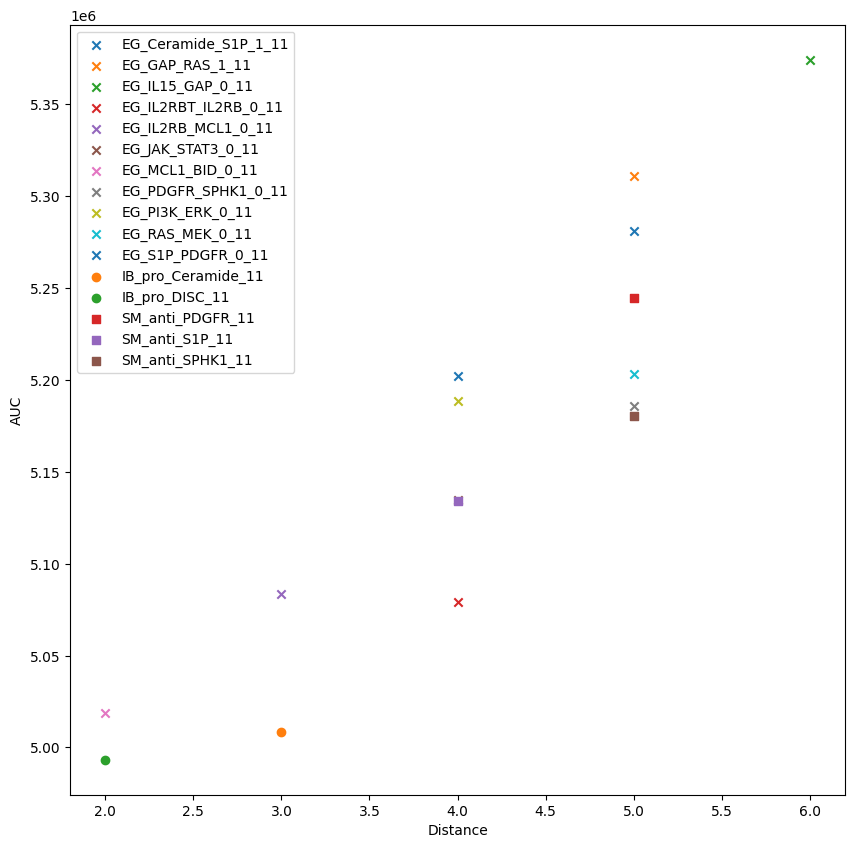

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    if col not in dists:
        continue
    auc = trapezoid(df[col].to_numpy()[0], x=df[time_col].to_numpy()[0])
    if auc < 9e6:
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(dists[col][0][0], auc, label=col, marker=marker)

ax.set_ylabel("AUC")
ax.set_xlabel("Distance")
ax.legend()

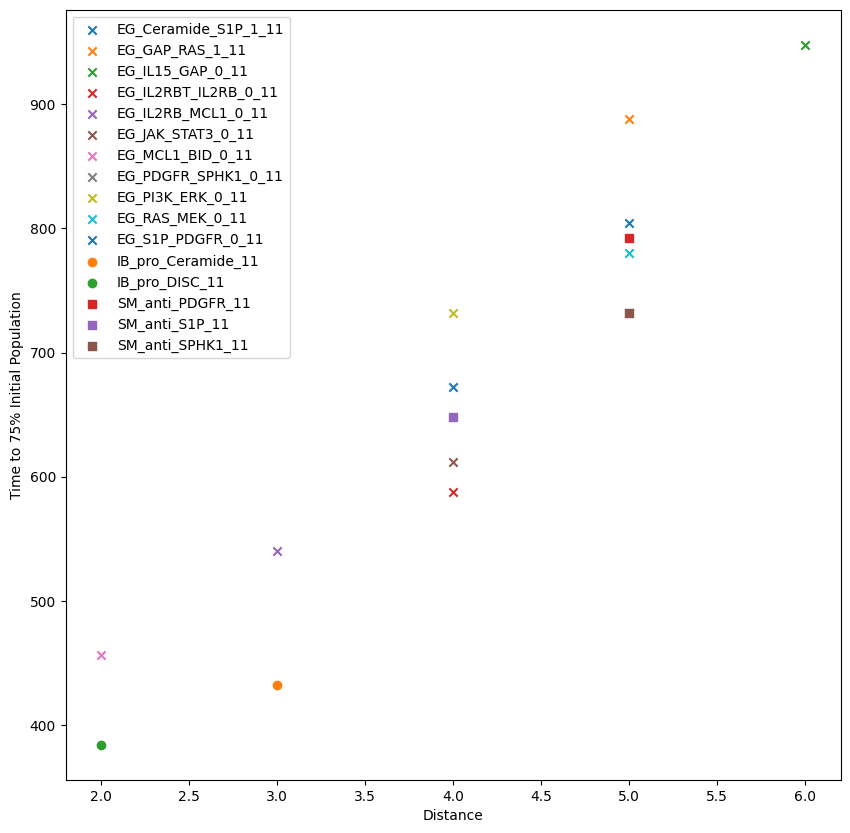

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    if col not in dists:
        continue
    vals = df[col].to_numpy()[0]
    t = df[time_col].to_numpy()[0]
    auc = trapezoid(vals, x=t)
    pop_ref = 1334 * 0.75

    if auc < 9e6:
        t_ref = t[min([i for i, x in enumerate(vals) if x < pop_ref])]
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(dists[col][0][0], t_ref, label=col, marker=marker)


ax.set_ylabel("Time to 75% Initial Population")
ax.set_xlabel("Distance")
ax.legend()

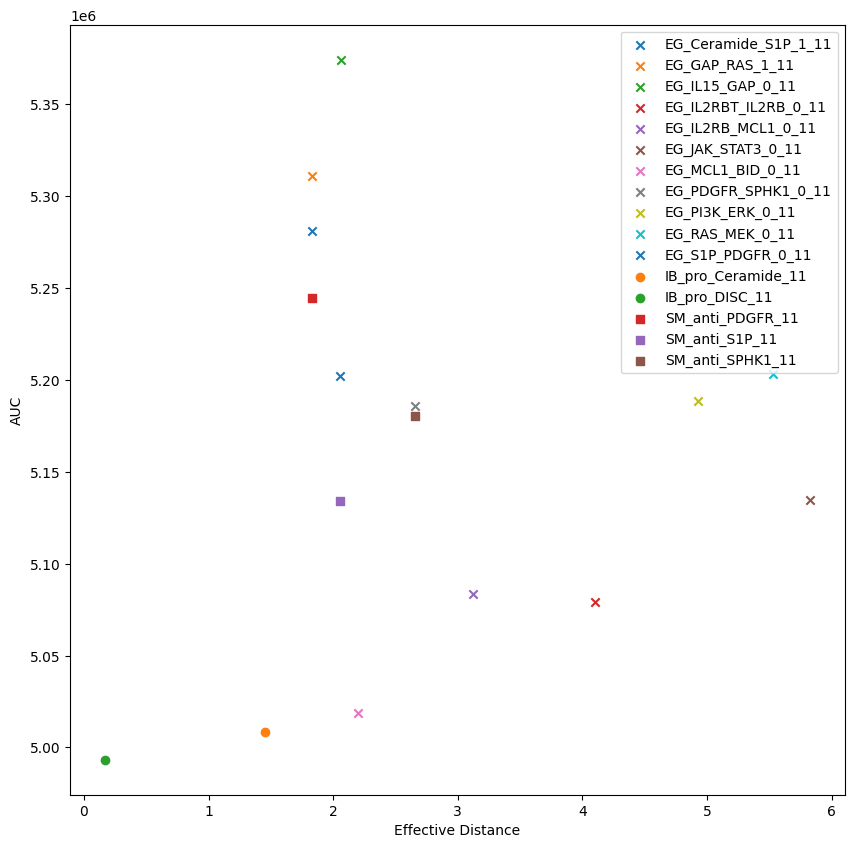

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    if col not in dists:
        continue
    auc = trapezoid(df[col].to_numpy()[0], x=df[time_col].to_numpy()[0])
    if auc < 9e6:
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(dists[col][0][1], auc, label=col, marker=marker)

ax.set_ylabel("AUC")
ax.set_xlabel("Effective Distance")
ax.legend()

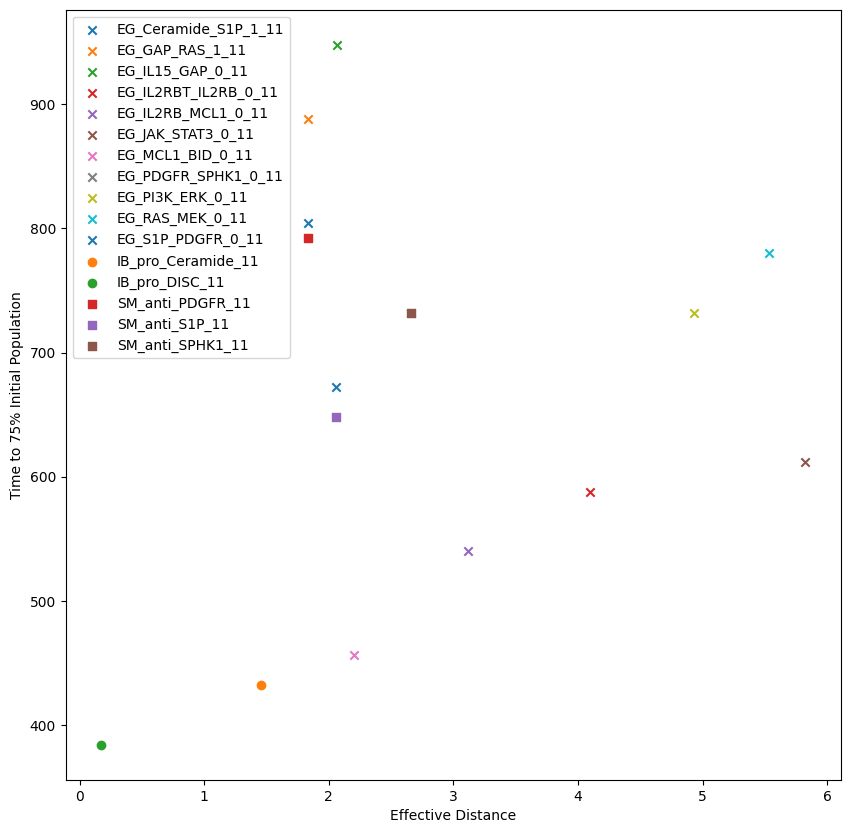

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    if col not in dists:
        continue
    vals = df[col].to_numpy()[0]
    t = df[time_col].to_numpy()[0]
    auc = trapezoid(vals, x=t)
    pop_ref = 1334 * 0.75

    if auc < 9e6:
        t_ref = t[min([i for i, x in enumerate(vals) if x < pop_ref])]
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(dists[col][0][1], t_ref, label=col, marker=marker)


ax.set_ylabel("Time to 75% Initial Population")
ax.set_xlabel("Effective Distance")
ax.legend()

In [209]:
df_raw = pd.read_csv(
    "../dataframes/aggregated_live_cells_time.csv", index_col=0, header=None
)
df_dict = {}
for row in df_raw.iterrows():
    if row[0] == "intervention":
        name = "time (minutes)"
    else:
        name = row[0]
    df_dict[name] = [np.array(row[1])]
df = pd.DataFrame(df_dict)
df

,time (minutes),EG_Ceramide_S1P_1_11,EG_Ceramide_S1P_1_12,EG_Ceramide_S1P_1_13,EG_Ceramide_S1P_1_21,EG_Ceramide_S1P_1_22,EG_Ceramide_S1P_1_23,EG_Ceramide_S1P_1_31,EG_Ceramide_S1P_1_32,EG_Ceramide_S1P_1_33,...,SM_pro_Ceramidepro_RAS_33,SM_pro_TBETpro_Ceramidepro_ERK_11,SM_pro_TBETpro_Ceramidepro_ERK_12,SM_pro_TBETpro_Ceramidepro_ERK_13,SM_pro_TBETpro_Ceramidepro_ERK_21,SM_pro_TBETpro_Ceramidepro_ERK_22,SM_pro_TBETpro_Ceramidepro_ERK_23,SM_pro_TBETpro_Ceramidepro_ERK_31,SM_pro_TBETpro_Ceramidepro_ERK_32,SM_pro_TBETpro_Ceramidepro_ERK_33
0,"[0.0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0, 84.0...","[1500.0, 1506.0, 1507.0, 1509.0, 1509.0, 1511....","[1500.0, 1503.0, 1503.0, 1507.0, 1510.0, 1511....","[1500.0, 1500.0, 1503.0, 1504.0, 1506.0, 1507....","[1500.0, 1503.0, 1504.0, 1505.0, 1506.0, 1507....","[1500.0, 1501.0, 1502.0, 1504.0, 1506.0, 1509....","[1500.0, 1502.0, 1502.0, 1504.0, 1508.0, 1510....","[1500.0, 1500.0, 1500.0, 1501.0, 1501.0, 1502....","[1500.0, 1502.0, 1502.0, 1503.0, 1504.0, 1504....","[1500.0, 1502.0, 1504.0, 1504.0, 1507.0, 1510....",...,"[1500.0, 1500.0, 1501.0, 1507.0, 1510.0, 1510....","[1500.0, 1500.0, 1501.0, 1503.0, 1504.0, 1505....","[1500.0, 1504.0, 1507.0, 1510.0, 1511.0, 1513....","[1500.0, 1501.0, 1504.0, 1505.0, 1505.0, 1506....","[1500.0, 1502.0, 1502.0, 1503.0, 1503.0, 1504....","[1500.0, 1500.0, 1502.0, 1503.0, 1504.0, 1506....","[1500.0, 1501.0, 1503.0, 1505.0, 1505.0, 1506....","[1500.0, 1501.0, 1504.0, 1506.0, 1507.0, 1507....","[1500.0, 1503.0, 1503.0, 1503.0, 1507.0, 1511....","[1500.0, 1504.0, 1506.0, 1508.0, 1509.0, 1512...."


Text(0.5, 0, 'AUC')

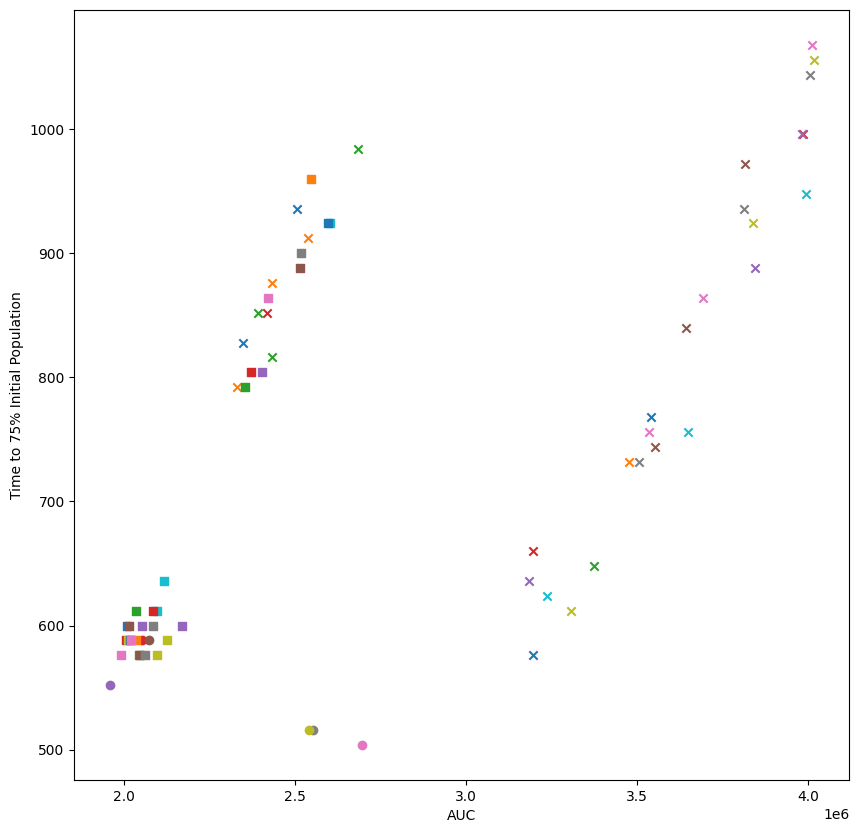

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    vals = df[col].to_numpy()[0]
    t = df[time_col].to_numpy()[0]
    auc = trapezoid(vals, x=t)
    pop_ref = 1500 * 0.75

    if col[-2] == "3":
        try:
            t_ref = t[min([i for i, x in enumerate(vals) if x < pop_ref])]
        except:
            continue
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(auc, t_ref, label=col, marker=marker)


ax.set_ylabel("Time to 75% Initial Population")
ax.set_xlabel("AUC")